1) TESTING DIFFERENT MODELS TO PREDICT INDEX PERFORMANCE

 i. LSTM
 ii. ARIMA
 iii. RANDOM FOREST
 iv. BROWNIAN MOTION

2) PROPOSALS OF INVESTMENTS PORTFOLIOS

 i. Markowitz’s Minimum-Variance Portfolio (MVP)
 ii. Traditional risk parity’s Inverse-Variance Portfolio (IVP)
 iii. Hierarchical Risk Parity (HRP)

In [3]:
#Defining libraries and dependencies
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import quandl 

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
quandl.ApiConfig.api_key = "qrtyy6k9BVDXhBK7AYo4"

%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import SGD



import scipy.cluster.hierarchy as sch
from datetime import date
from matplotlib import pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
from alpha_vantage.timeseries import TimeSeries
import ffn
import config
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


,Close
Date,
2010-10-01,38.81
2010-10-04,38.95
2010-10-05,39.64
2010-10-06,39.90
2010-10-07,39.52


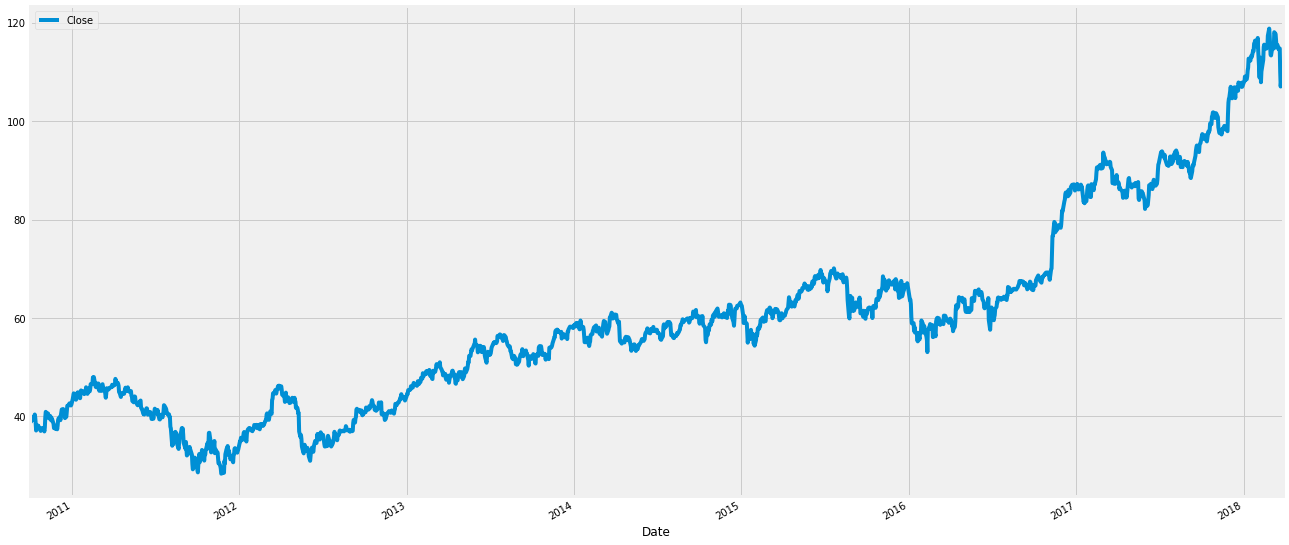

In [39]:
#Getting Data

start = "2010-10-01"
end = "2018-06-30"

df = quandl.get("WIKI/JPM.4",start_date=start, end_date=end)
df.plot(figsize=(20,10))
df.head()

i. TimeSeriesPrediction_LSTM

In [5]:
dataset = df

In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#print(len(train), len(test))

In [8]:
# convert an array of values into a dataset matrix
# Give X look_back time what will tomorrows prediction be?
def create_dataset(dataset, look_back=8):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [9]:
# reshape into X=t and Y=t+1
import numpy as np
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [10]:
sgd = SGD(lr=0.1)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(1, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=sgd)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=20)])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 4s - loss: 2.1092e-04
Epoch 2/50
 - 4s - loss: 1.4105e-04
Epoch 3/50
 - 4s - loss: 1.4019e-04
Epoch 4/50
 - 4s - loss: 1.3699e-04
Epoch 5/50
 - 4s - loss: 1.3206e-04
Epoch 6/50
 - 4s - loss: 1.3922e-04
Epoch 7/50
 - 4s - loss: 1.3519e-04
Epoch 8/50
 - 6s - loss: 1.3621e-04
Epoch 9/50
 - 6s - loss: 1.3279e-04
Epoch 10/50
 - 6s - loss: 1.3468e-04
Epoch 11/50
 - 5s - loss: 1.2712e-04
Epoch 12/50
 - 5s - loss: 1.3061e-04
Epoch 13/50
 - 6s - loss: 1.2786e-04
Epoch 14/50
 - 6s - loss: 1.2611e-04
Epoch 15/50
 - 6s - loss: 1.2592e-04
Epoch 16/50
 - 5s - loss: 1.2569e-04
Epoch 17/50
 - 5s - loss: 1.2622e-04
Epoch 18/50
 - 6s - loss: 1.2492e-04
Epoch 19/50
 - 6s - loss: 1.2177e-04
Epoch 20/50
 - 5s - loss: 1.2381e-04
Epoch 21/50
 - 6s - loss: 1.2151e-04
Epoch 22/50
 - 5s - loss: 1.2121e-04
Epoch 23/50
 - 5s - loss: 1.2105e-04
Epoch 24/50
 - 5s - loss: 1.2195e-04
Epoch 25/50
 - 5s - loss: 1.2373e-04
Epoch 26/50
 - 5s - loss: 1.2145e-04

In [13]:
model.save("jpm_ohlc.h5")

In [14]:
from keras.models import load_model
model = load_model("jpm_ohlc.h5")

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [16]:
fake_10 = [[100,101,110,105,100,101,110,105,120,130]]
processed_fake_10 = scaler.transform(fake_10)
processed_fake_10.reshape(1,10,1)
output = model.predict(processed_fake_10.reshape(1,10,1))
scaler.inverse_transform(output)

array([[108.92322]], dtype=float32)

In [17]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [21]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' %(trainScore))
LSTM_RMSE = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('LSTM RMSE: %.2f RMSE' % (LSTM_RMSE))

Train Score: 0.86 RMSE
LSTM RMSE: 4.50 RMSE


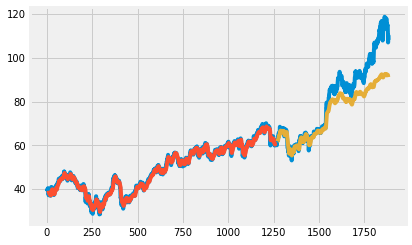

In [75]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

ii. Autoregressive integrated moving average (ARIMA)

In [25]:
# The 'MS' string groups the data in buckets by start of the month
y=df
y = y['Close'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

In [26]:
#Parameter Selection for the ARIMA Time Series Model


# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [27]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=True)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:992.6612396436049
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:803.5758262952763
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:626.3292539269273
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:586.9622474447694
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:560.3309446421576
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:538.461809770981
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:535.1751397816398
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:442.7820020332372
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:385.3967345956568
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:414.55839534054263
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:334.5336107701855
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:388.83651849107423
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:386.63172966865386
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:341.5030371383523
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:336.7832342032235
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:421.6769146585377
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:369.5056264331548
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:399.35375080019105
ARIMA(0

In [28]:
#Fitting an ARIMA Time Series Model
mod_goog = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod_goog.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2126      0.191     -1.112      0.266      -0.587       0.162
ma.L1          0.7264      0.152      4.784      0.000       0.429       1.024
ar.S.L12      -0.7525      0.142     -5.297      0.000      -1.031      -0.474
ma.S.L12       0.5585      0.224      2.498      0.012       0.120       0.997
sigma2         7.6950      1.341      5.738      0.000       5.066      10.324


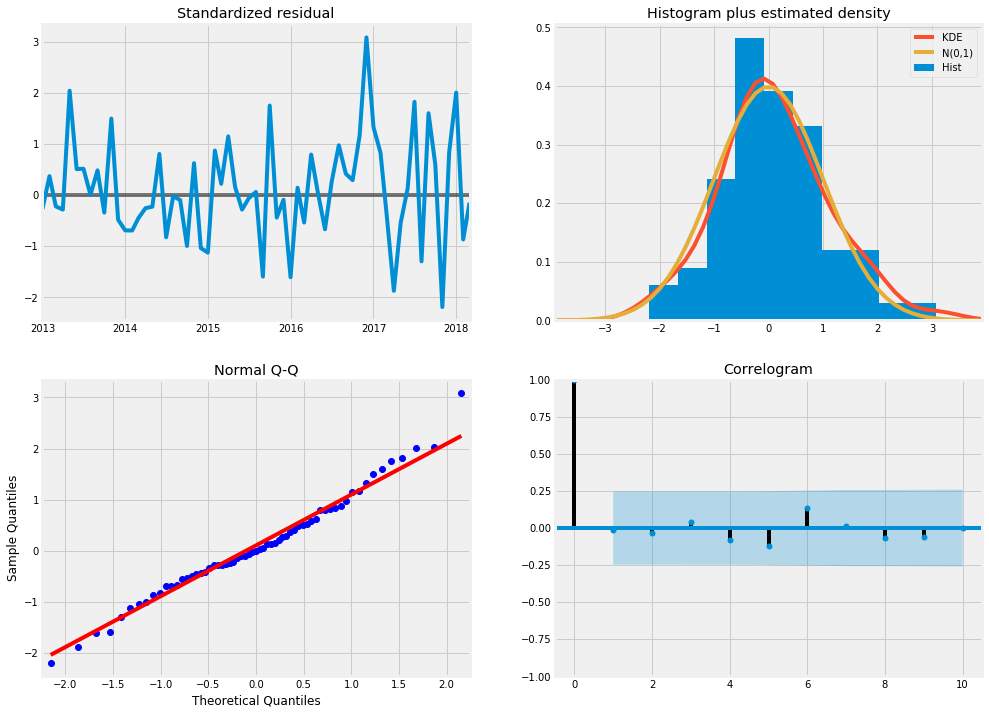

In [29]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [30]:
# Validating Forecasts
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()

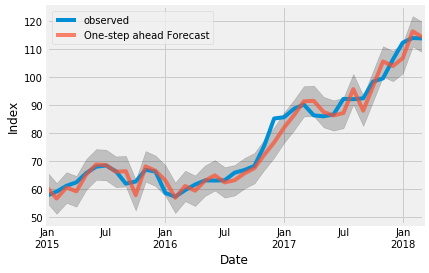

In [31]:
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Index')
plt.legend()

plt.show()

In [32]:
y_forecasted = pred.predicted_mean
y_truth = y['2015-01-01':]

# Compute the mean square error
mse_ARIMA = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our ARIMA forecasts is {}'.format(round(mse_ARIMA, 2)))

The Mean Squared Error of our ARIMA forecasts is 9.94


In [33]:
# A better representation of our true predictive power can be obtained using dynamic 
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

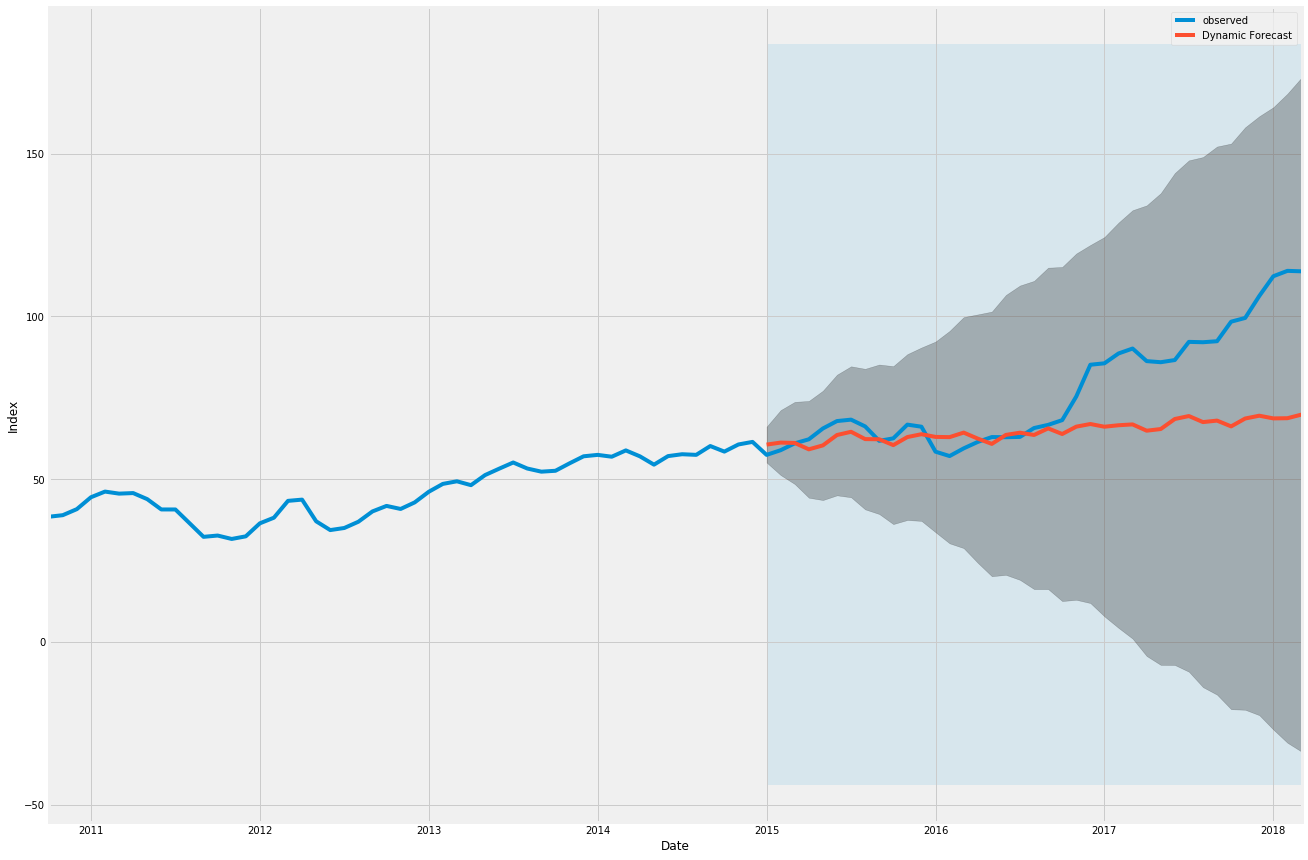

In [34]:
ax = y['2010':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Index')

plt.legend()
plt.show()

In [27]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2015-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 364.24


In [28]:
#Producing and Visualizing Forecasts


# Get forecast # steps ahead in future
pred_uc = results.get_forecast(steps=40)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

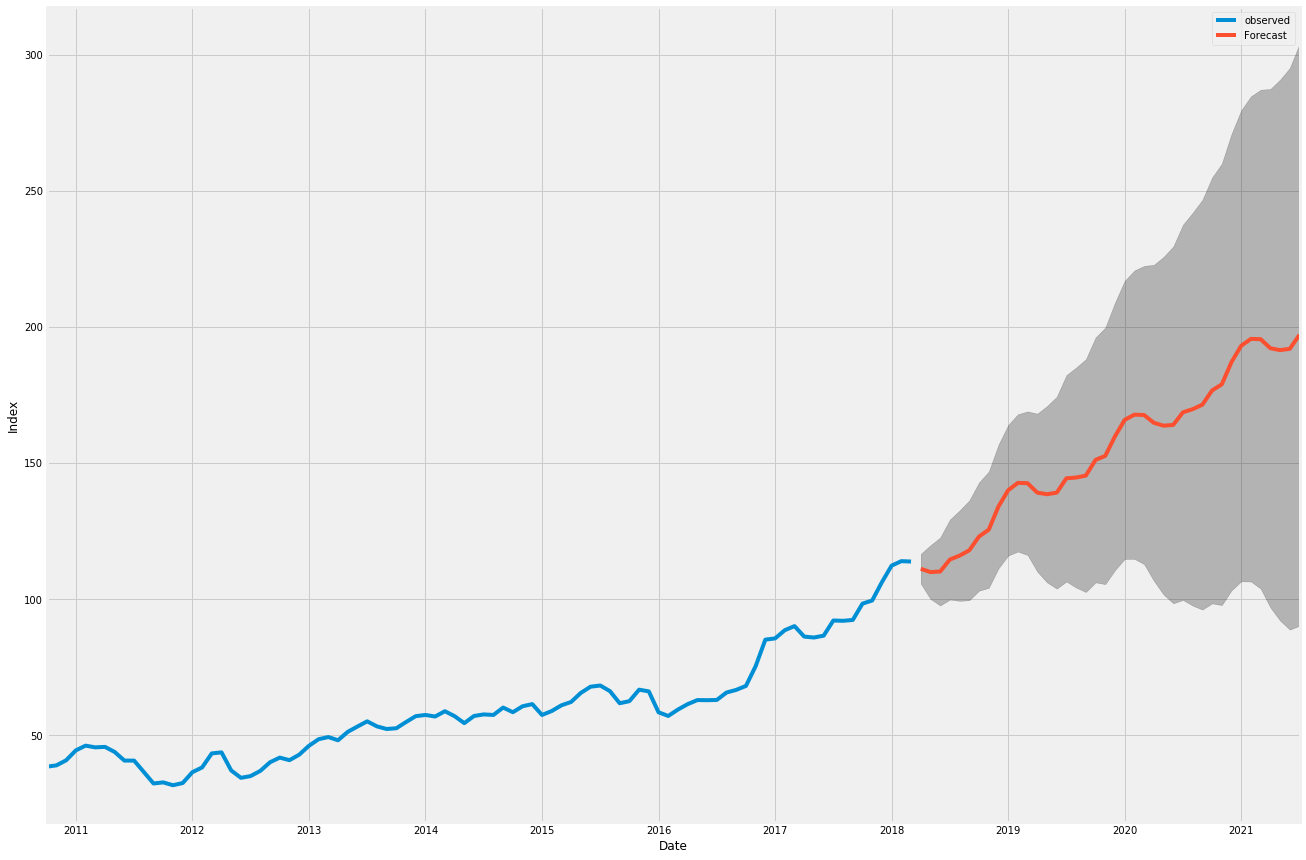

In [29]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Index')

plt.legend()
plt.show()

iii. RANDOM FOREST REGRESSION


In [40]:
df['X'] = range(1, len(df) + 1)
df = df[['X', 'Close']]


In [41]:
df.as_matrix()
df_to_nparray = df.to_records(index=False)
df_to_nparray


rec.array([(   1,  38.81), (   2,  38.95), (   3,  39.64), ...,
           (1881, 107.01), (1882, 110.31), (1883, 108.17)],
          dtype=[('X', '<i4'), ('Close', '<f8')])

In [42]:
df_to_nparray=df_to_nparray.reshape(-1, 1)

In [43]:
X=df_to_nparray['X']
y=df_to_nparray['Close']

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

In [45]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

In [46]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test) 


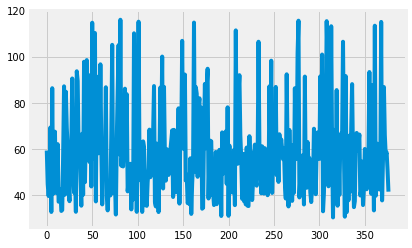

In [47]:

plt.plot(y_pred)

In [49]:
from sklearn import metrics
RF_RMSE =  metrics.mean_squared_error(y_test, y_pred) 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  
print(RF_RMSE)

Mean Absolute Error: 0.5235513262599456
Mean Squared Error: 0.5189946211472127
Root Mean Squared Error: 0.7204128130087726
0.5189946211472127


<ErrorbarContainer object of 3 artists>

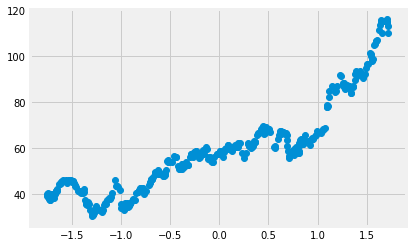

In [39]:
#plots https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html
plt.errorbar(X_test, y_pred, 0.3,fmt='o')

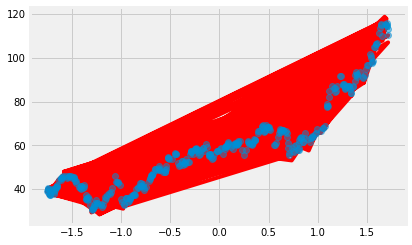

In [40]:
from sklearn.ensemble import RandomForestRegressor

plt.errorbar(X_test, y_pred, 0.3, fmt='o', alpha=0.5)
plt.plot(X_train, y_train, '-r');


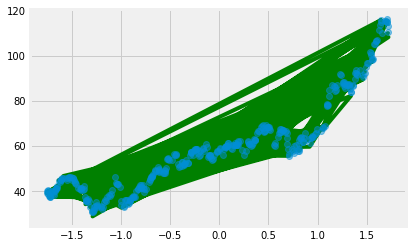

In [41]:
plt.errorbar(X_test, y_pred, 0.3, fmt='o', alpha=0.5)
#plt.plot(X_train, y_train, '-r');
plt.plot(X_test, y_test, '-g');

In [85]:

TABLE=[LSTM_RMSE,mse_ARIMA,RF_RMSE]
Summary= pd.DataFrame(TABLE)
Summary

,0
0,4.496038
1,9.937446
2,0.518995


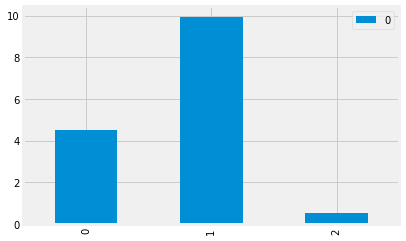

In [87]:
df.plot(kind="bar")
plt.show()

<BarContainer object of 3 artists>

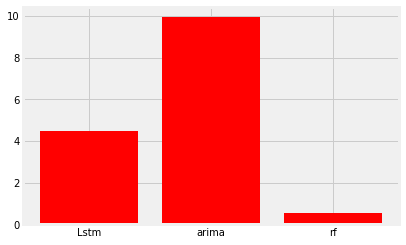

In [89]:
score= [4.496038,9.937446,0.518995]
x_axis= ("Lstm","arima","rf")
plt.bar(x_axis,score, color="r", align= "center")